In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from itertools import zip_longest

import torch
from torch import nn

In [2]:
class Function(nn.Module):
    def __init__(self, a, b):
        super().__init__()
        self.a = nn.Parameter(torch.tensor(a, dtype=torch.float32))
        self.b = nn.Parameter(torch.tensor(b, dtype=torch.float32))
    def forward(self):
        return ((self.a * self.b) - 2)**2
    def compute_loss_at_point(self, a, b):
        return ((a * b) - 2)**2

In [3]:
# init_points = [[2, 3], [1, 6]]
init_points = [[3, 3], [1, 9]]
init_description = [r'$a_{init} = $' + f' {a}' + r', $b_{init} = $' + f' {b}' for a,b in init_points]

lr = 0.01
# 0.01
# 0.02
# 0.025

### Training

In [4]:
all_pathes = []
for init in init_points:
  f = Function(init[0], init[1])
  opt = torch.optim.SGD(f.parameters(), lr=lr)

  a_history = []
  b_history = []
  loss_prev = 0.0
  # max_steps = 100
  max_steps = 50
  for step in range(max_steps):
    opt.zero_grad()
    loss = f()
    loss.backward()
    a_history.append(f.a.detach().clone().numpy())
    b_history.append(f.b.detach().clone().numpy())
    opt.step()

    # if np.abs(loss_prev - loss.detach().numpy()) < 1e-6:
    #   break
    loss_prev = loss.detach().numpy()
  print("{} training done!".format(init))
  print("  steps: {}  loss: {:.6f}  a: {:.5f}  b: {:.5f}".format(step+1, f().detach().numpy(), f.a.detach().numpy(), f.b.detach().numpy()))

  a_history = np.array(a_history)
  b_history = np.array(b_history)
  path = np.concatenate((np.expand_dims(a_history, 1), np.expand_dims(b_history, 1)), axis=1).T
  all_pathes.append(path)

[3, 3] training done!
  steps: 50  loss: 0.000481  a: 1.42195  b: 1.42195
[1, 9] training done!
  steps: 50  loss: 0.000000  a: 0.22699  b: 8.81091


### Static contour plot with optimization path

In [5]:
number_of_points = 500
# margin = 4.5
# margin = 8.5
margin = 10.5
x_min = 0. - margin
x_max = 0. + margin
y_min = 0. - margin
y_max = 0. + margin
x_points = np.linspace(x_min, x_max, number_of_points)
y_points = np.linspace(y_min, y_max, number_of_points)
x_mesh, y_mesh = np.meshgrid(x_points, y_points)
z = np.array([f.compute_loss_at_point(xps, yps) for xps, yps in zip(x_mesh, y_mesh)])

In [6]:
import matplotlib

matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    "legend.fontsize": 18,
    "axes.labelsize": 20,
    "axes.titlesize": 26,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
})

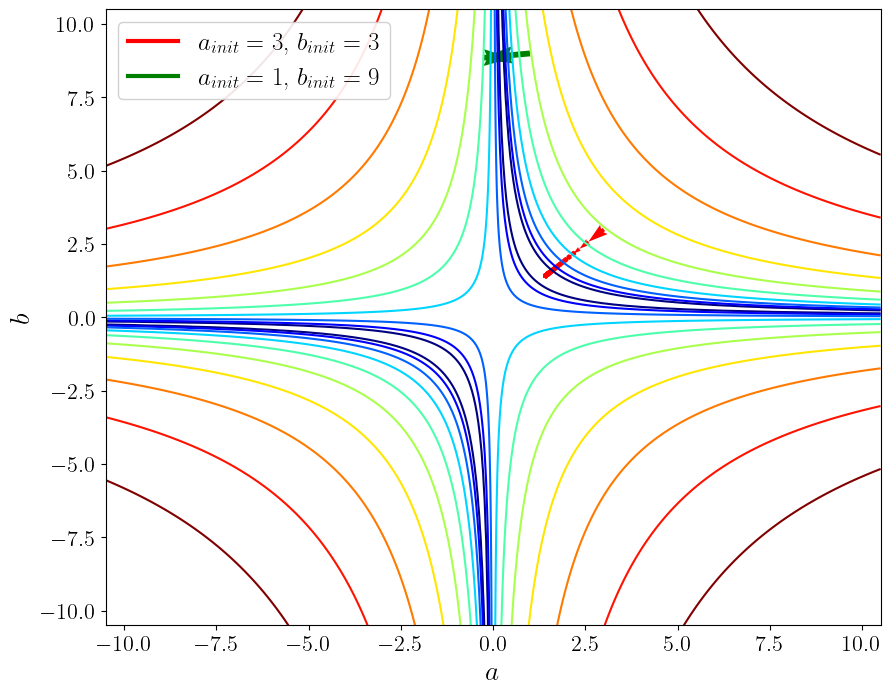

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.contour(x_mesh, y_mesh, z, levels=np.logspace(-0.5, 3.5, 10), norm=LogNorm(), cmap=plt.cm.jet)

# ax.plot(*minima, 'r*', markersize=20)
colors = ['red', 'green', 'blue', 'orange', 'purple', 'magenta']
for name, path, color in zip(init_description, all_pathes, colors):
  ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1],
            scale_units='xy', angles='xy', scale=1, color=color, lw=3)
  ax.plot([], [], color=color, label=name, lw=3)

ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

ax.legend(loc='upper left', fancybox=True, framealpha=0.9)
plt.show()

### Animiating contour plot with optimization path

In [8]:
class TrajectoryAnimation(animation.FuncAnimation):
  def __init__(self, *paths, labels=[], colors=[], fig=None, ax=None, frames=None, 
               interval=60, repeat_delay=5, blit=True, **kwargs):
    if fig is None:
      if ax is None:
        fig, ax = plt.subplots()
      else:
        fig = ax.get_figure()
    else:
      if ax is None:
        ax = fig.gca()

    self.fig = fig
    self.ax = ax

    self.paths = paths

    if frames is None:
      frames = max(path.shape[1] for path in paths)

    self.lines = [ax.plot([], [], label=label, color=color, lw=3)[0] 
                  for _, label, color in zip_longest(paths, labels, colors)]
    self.points = [ax.plot([], [], 'o', color=line.get_color())[0] 
                   for line in self.lines]

    super(TrajectoryAnimation, self).__init__(fig, self.animate, init_func=self.init_anim,
                                              frames=frames, interval=interval, blit=blit,
                                              repeat_delay=repeat_delay, **kwargs)

  def init_anim(self):
    for line, point in zip(self.lines, self.points):
      line.set_data([], [])
      point.set_data([], [])
    return self.lines + self.points

  def animate(self, i):
    for line, point, path in zip(self.lines, self.points, self.paths):
      line.set_data(*path[::,:i])
      point.set_data(*path[::,i-1:i])
    return self.lines + self.points

Text(0.5, 1.0, 'Learning Rate = 0.01')

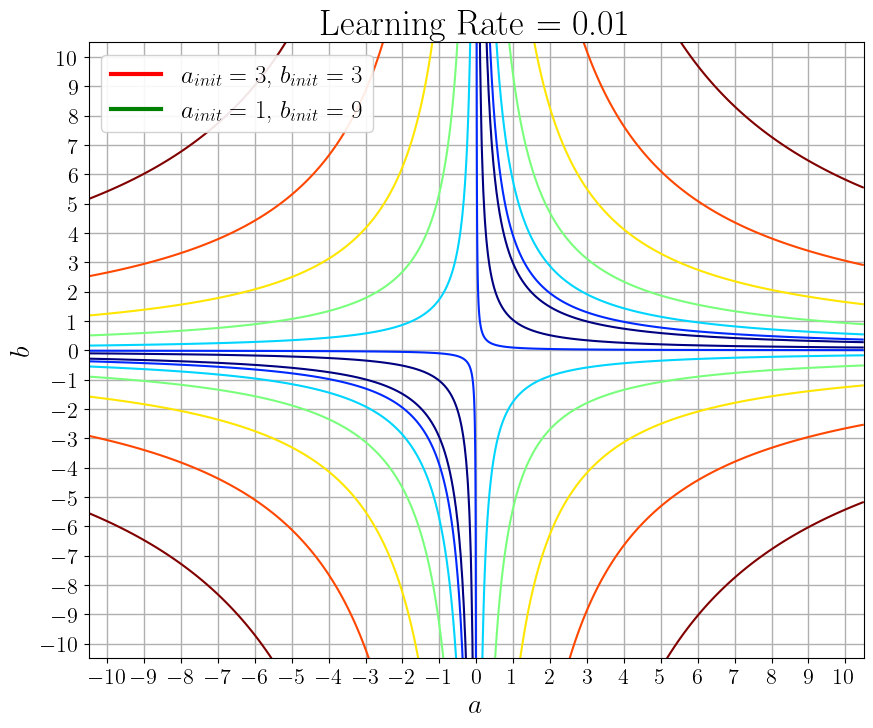

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))

# plt.contour(x_mesh, y_mesh, z, levels=np.logspace(-0.5, 3.5, 10), norm=LogNorm(), cmap=plt.cm.jet)
plt.contour(x_mesh, y_mesh, z, levels=np.logspace(-0.03, 3.5, 7), norm=LogNorm(), cmap=plt.cm.jet)
# plt.contour(x_mesh, y_mesh, z, levels=np.logspace(0, 3.5, 5), norm=LogNorm(), cmap=plt.cm.jet)


ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$b$')

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))
ax.grid(linewidth=1)

# ticks = [0,1,2,3,4,5,6,7,8,9]
# ticks = np.line
ticks = np.arange(-10, 11, 1)

ax.set_xticks(ticks)
ax.set_yticks(ticks)

path_animation = TrajectoryAnimation(*all_pathes, labels=init_description, colors=colors, ax=ax)

ax.legend(loc='upper left', fancybox=True, framealpha=0.9)
ax.set_title(f'Learning Rate = {lr}')

In [10]:
HTML(path_animation.to_html5_video())

### Save to `mp4` file

In [11]:
file_name = f'animations/animation_video_lr_{lr}.mp4'
path_animation.save(file_name, dpi=1500)
!ffmpeg -y -i 'animations/animation_video_lr_{lr}.mp4' -s 1500x1200 'animations/animation_gif_lr_{lr}.gif'